In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled)


In [2]:
%matplotlib inline
import utils_modified; reload(utils_modified)
from utils_modified import *
from __future__ import division, print_function

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
Using Theano backend.


In [138]:
import numpy as np
import random
import sys

from numpy.random import normal
import matplotlib.pyplot as plt

In [79]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, Activation, merge, Flatten, Dropout, Lambda
from keras.layers import LSTM, SimpleRNN
from keras.models import Model, Sequential
from keras.engine.topology import Merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.convolutional import *
from keras import backend as K
from keras.utils.data_utils import get_file

In [80]:
# https://keras.io/getting-started/sequential-model-guide/

In [81]:
#?? SimpleRNN

In [82]:
look_back = 5
model = Sequential()
#model.add(LSTM(4, input_dim=look_back))
model.add(SimpleRNN(return_sequences=False, unroll=False, output_dim=1, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [204]:
#print(dir(rnn))

In [232]:
I = Input(shape=(look_back,1), dtype='float32')
I2 = Lambda(lambda x:x*x, output_shape=(look_back,1,))([I])
rnn = SimpleRNN(return_sequences=True, unroll=False, output_dim=1, input_dim=look_back)
O1 = rnn(I2)
O2 = Lambda(lambda x:K.abs(x)+0.000001, output_shape=(look_back,1,))([O1]) # insure positive var
V = Lambda(lambda x:K.sqrt(x), output_shape=(look_back,1,))([O2]) # get volatility

def llklh(args):
    var_t, eps2_t = args
    return -math.log(math.sqrt(2*math.pi)) -0.5*K.log(var_t) -0.5*(eps2_t/var_t)

Errors = Lambda(llklh, output_shape=(look_back,1,))([O2,I2])

modelT = Model(input=I, output=Errors)

def special_loss(dummy, errorterms):
    return errorterms

modelT.compile(optimizer='adadelta', loss=special_loss)

modelV = Model(input=I, output=V)

In [233]:
I._keras_shape, I2._keras_shape, O1._keras_shape, O2._keras_shape

((None, 5, 1), (None, 5, 1), (None, 5, 1), (None, 5, 1))

In [234]:
onearr = np.ones((3, look_back, 1)).astype('float32')
print(I2.eval({I:onearr}).shape)
print(O1.eval({I:onearr}).shape)
print(O2.eval({I:onearr}).shape)
print(modelT.predict(onearr).shape)

(3, 5, 1)
(3, 5, 1)
(3, 5, 1)
(3, 5, 1)


In [235]:
modelT.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_31 (InputLayer)            (None, 5, 1)          0                                            
____________________________________________________________________________________________________
lambda_28 (Lambda)               (None, 5, 1)          0           input_31[0][0]                   
____________________________________________________________________________________________________
simplernn_37 (SimpleRNN)         (None, 5, 1)          3           lambda_28[0][0]                  
____________________________________________________________________________________________________
lambda_29 (Lambda)               (None, 5, 1)          0           simplernn_37[0][0]               
___________________________________________________________________________________________

In [236]:
kappa = 0.000003
alpha = 0.50
beta = 0.40
lvar = kappa / (1-alpha-beta)
print(math.sqrt(lvar)*math.sqrt(255))

0.0874642784227


In [237]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#train = [math.sin(x*0.2) for x in range(250*3)]
train = []
trainvars = []
var_t = lvar
for t in range(250*3):
    eps = math.sqrt(var_t) * normal()
    var_t = kappa + alpha * var_t + beta * (eps*eps)
    train.append(eps)
    trainvars.append(var_t)
train = np.array(train).reshape(-1,1)
trainX, trainY = create_dataset(train, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#print(trainX, trainY)

In [249]:
print( modelT.predict(trainX.transpose((0,2,1))[0:1,:,:]) )
print('-------------------------')
print( modelV.predict(trainX.transpose((0,2,1))[10:13,:,:]) )

[[[ 0.88765115]
  [ 1.62400794]
  [ 0.76384699]
  [ 1.16656303]
  [ 0.62168086]]]
-------------------------
[[[ 0.16421291]
  [ 0.07850411]
  [ 0.18582118]
  [ 0.1243237 ]
  [ 0.2143141 ]]

 [[ 0.16421321]
  [ 0.07850993]
  [ 0.18582441]
  [ 0.12432946]
  [ 0.21432444]]

 [[ 0.1642108 ]
  [ 0.07850324]
  [ 0.18582106]
  [ 0.1243125 ]
  [ 0.21430735]]]


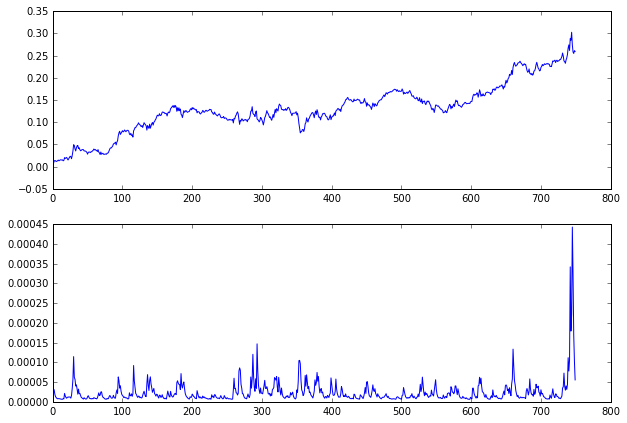

In [239]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(np.cumsum(train))
plt.subplot(2,1,2)
plt.plot(trainvars)
plt.show()

In [240]:
trainX.shape, trainY.shape, trainX.transpose((0,2,1)).shape

((744, 1, 5), (744,), (744, 5, 1))

In [242]:
#modelT.fit(trainX, trainY, nb_epoch=100, batch_size=50, verbose=1)

modelT.fit(trainX.transpose((0,2,1)), trainX.transpose((0,2,1)), nb_epoch=10, batch_size=32, verbose=1)

Epoch 1/10
744/744 [==============================] - 0s - loss: 2.5605     
Epoch 2/10
744/744 [==============================] - 0s - loss: 2.0945     
Epoch 3/10
744/744 [==============================] - 0s - loss: 1.8953     
Epoch 4/10
744/744 [==============================] - 0s - loss: 1.7369     
Epoch 5/10
744/744 [==============================] - 0s - loss: 1.5972     
Epoch 6/10
744/744 [==============================] - 0s - loss: 1.4703     
Epoch 7/10
744/744 [==============================] - 0s - loss: 1.3541     
Epoch 8/10
744/744 [==============================] - 0s - loss: 1.2474     
Epoch 9/10
744/744 [==============================] - 0s - loss: 1.1491     
Epoch 10/10
744/744 [==============================] - 0s - loss: 1.0583     


In [8]:
lag = look_back

In [9]:
def show_top_next(mdl, inp, steps=1):
    inp = np.copy(inp)
    for k in range(steps):
        #ps = mdl.predict([np.array([i]) for i in inp])
        ps = mdl.predict(inp)
        newimp = np.concatenate((inp[0,:,:],ps), axis=1)
        inp[0,:,:] = newimp[:,1:]
    return inp

In [10]:
cut = 10
inps = [trainX[10:(cut+1),:,:], ]
for iter in range(8):
    inps.append( show_top_next(model, inps[-1], 5) )

print(inps[0])
print(inps[1])
print(inps[2])

[[[ 0.90929743  0.8084964   0.67546318  0.51550137  0.33498815]]]
[[[ 0.14971432 -0.0566142  -0.27141064 -0.47336614 -0.64913946]]]
[[[-0.79665715 -0.90304971 -0.96826339 -0.99756896 -0.98139274]]]


In [13]:
TSmodel = np.concatenate(inps, axis=2)[0,0]
TSreal = trainX[range(cut,cut+5*len(inps),5),:,:].reshape((1,1,-1))[0,0]

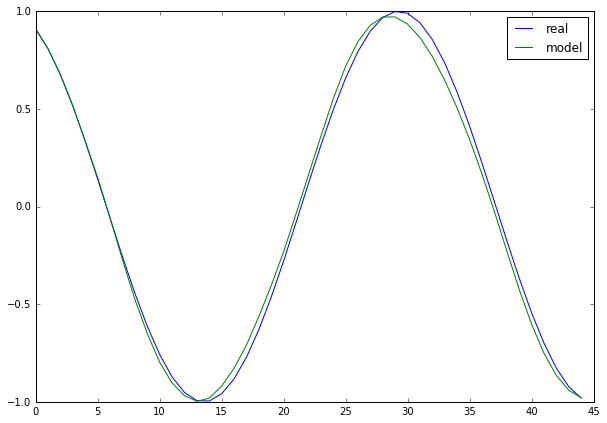

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(TSreal)
plt.plot(TSmodel)
plt.legend(['real','model'], loc='upper right')
plt.show()